## Algorithm 1: Scheme of subtasks for tree detection and diameter calculation.

in linux


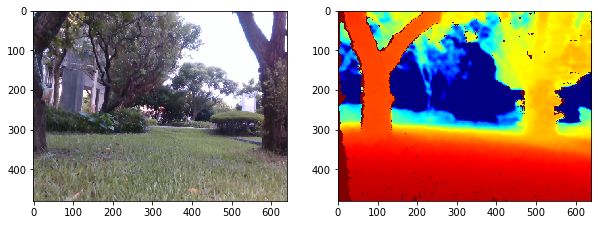

In [1]:
'''math tool'''
import csv
import numpy as np
from scipy.spatial import distance as dist

'''plot tool'''
import matplotlib.pyplot as plt

'''image tool'''
import cv2
import statistics as sta

import utm
from pyproj import Proj
import time
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/mapping_node/mapping_ws/src/mapping_explorer/0906_demo_data/2tree/"
    # test_data/
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
else:
    file_path = r"C:/Users/15sin/OneDrive/文件/GitHub/mapping_explorer/test_data/"

cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424

npDepth = np.load(file_path+"depth.npy")
npColor = np.load(file_path+"color.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

## Algorithm 2: Detection of trees in point clouds.

### 1. at different heights hi, slices of thickness t, project all points within onto a plane li parallel to xy-plane

In [3]:
def depth_Z(u,v):
    return npDepth[v][u]

float16


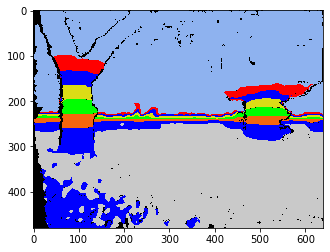

In [4]:
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<-50]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<300,npHeight>-50)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))


### case01: in the middle (orange area)

(125, 75)

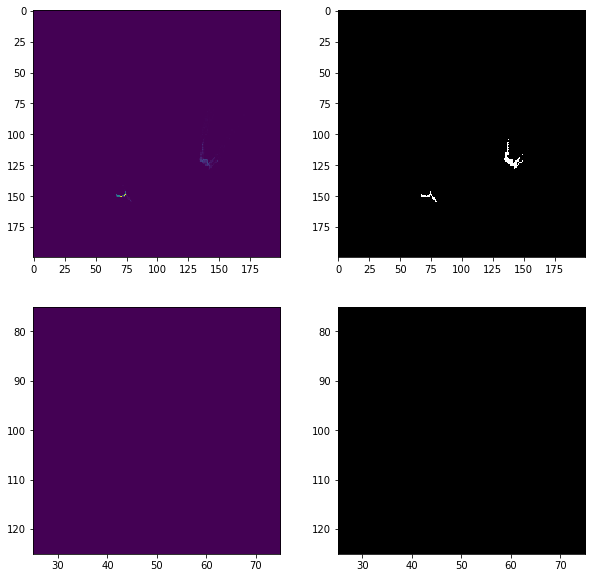

In [5]:
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape
scan_height_ = 10
center_y = row/2
offset = int(center_y - scan_height_/2 );

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)

                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100]+=1
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l1)

plane_l1_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l1_copy[plane_l1>4]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l1)
plt.xlim((25,75))
plt.ylim((125,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

### check if correct

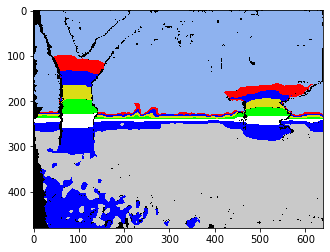

In [6]:
# mark white
npHeight_seg[height_layer]=255
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

### case02: different layer (green area)

(125, 75)

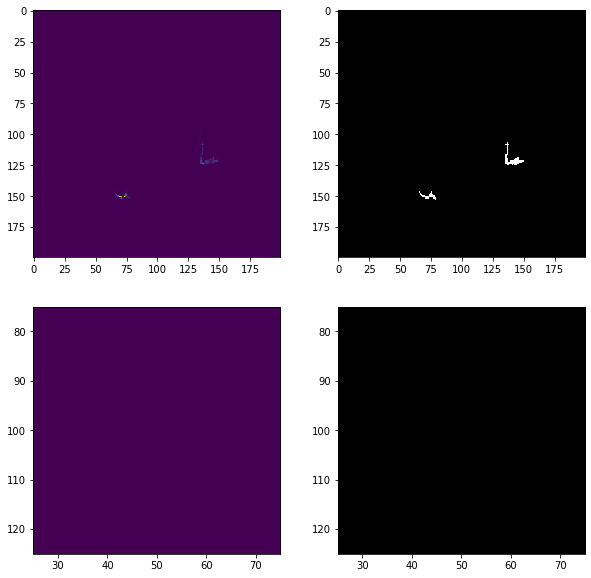

In [7]:
height_layer = np.logical_and(npHeight<700,npHeight>500)

plane_l2 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l2[200-int(z_depth/50)][int(x_depth/50)+100]+=1
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l2)

plane_l2_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l2_copy[plane_l2>4]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l2)
plt.xlim((25,75))
plt.ylim((125,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

(125, 75)

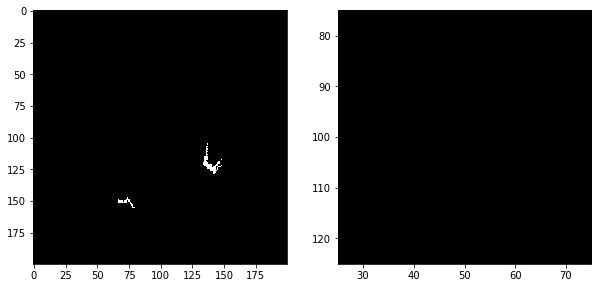

In [10]:
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[np.logical_or(plane_l1_copy,plane_l2_copy)]=255
# hieght_or = np.copy(plane_l1_copy)
fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

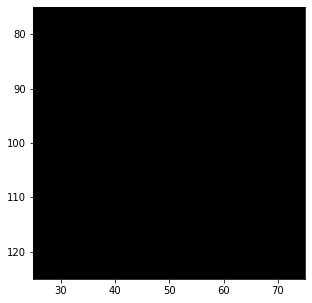

In [11]:
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)
hieght_or = cv2.erode(hieght_or, kernel, iterations = 1)

fig.ax = plt.subplots(figsize=(5,5))
plt.xlim((25,75))
plt.ylim((125,75))
plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

### The circle equation
### find connected component and push into point array A

>>>>num_objects: 4
# of points:  (94, 3)
x,y,r:  117 143 8
# of points:  (1, 3)
# of points:  (30, 3)
x,y,r:  154 73 5


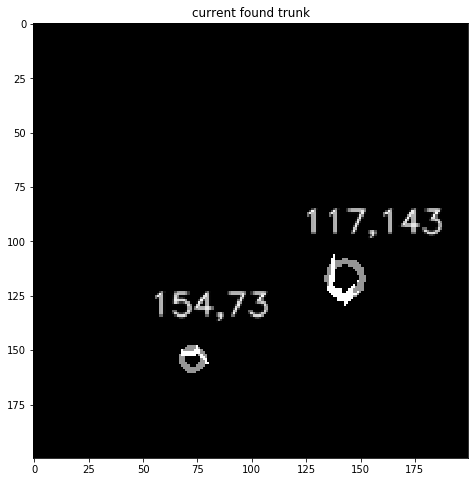

In [26]:
num_objects, labels = cv2.connectedComponents(hieght_or)
centre_x_list = []
centre_y_list = []
circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)
for i in range(num_objects-1):
    A = []
    for x in range(200):
        for y in range(200):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    cv2.circle(circle_bd,(int(centre_y+0.5), int(centre_x+0.5)), int(radius_r+0.5), 150, 2)
    
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))

    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x+0.5))+','+str(int(centre_y+0.5)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.5, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke
circle_bd[hieght_or==255]=255
centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)

fig3 = plt.figure(figsize=(8,8))
plt.title('current found trunk')
# plt.xlim((25,85))
# plt.ylim((125,65))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

### load landmark map

[[ 352847.76728117  352851.45617005  352865.55140815  352870.92283672]
 [2767650.49778999 2767651.60890111 2767652.14223444 2767648.74223444]]


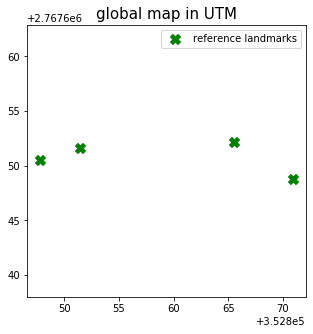

In [13]:
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path_map = directory+bag_name
center_utm_ref = np.load(file_path_map+'center_utm_ref.npy')
print(center_utm_ref)
cX_utm_ref = center_utm_ref[0,:]
cY_utm_ref = center_utm_ref[1,:]
fig4 = plt.figure(figsize=(5,5))
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='reference landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.axis('equal')
plt.title('global map in UTM', fontsize=15)
plt.legend()
plt.draw()

### test data

In [14]:
with open(file_path+'cb_pose.csv', 'r') as csvfile:
    imu_yaw, lat, lng = csv.reader(csvfile, delimiter=',')
imu_yaw = float(imu_yaw[0])
lat = float(lat[0])
lng = float(lng[0])

_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lng, lat)

cX_m_loc = (centre_y_list-100)*0.05
cY_m_loc = (200-centre_x_list)*0.05
cX_utm_loc = cX_m_loc*np.cos(imu_yaw)-cY_m_loc*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc = cX_m_loc*np.sin(imu_yaw)+cY_m_loc*np.cos(imu_yaw) + utm_y_loc
center_utm_loc = np.vstack((cX_utm_loc,cY_utm_loc))
np.save(file_path+'center_utm_loc', center_utm_loc)

### find rigid transformation

In [25]:
centre_y_list

array([143,  73])

In [16]:
center_utm_loc = np.vstack((cX_utm_loc,cY_utm_loc))
P = center_utm_ref
# U = center_utm_loc
U = U_new
print(P)
print(U)

[[ 352847.76728117  352851.45617005  352865.55140815  352870.92283672]
 [2767650.49778999 2767651.60890111 2767652.14223444 2767648.74223444]]
[[ 352846.13027041  352850.05328724]
 [2767650.00297383 2767650.53442369]]


In [17]:
def find_second(row_index, first_min):
    second_min = 100
    sm_index = 0
    row_list = D[row_index,:]
    for i in range(len(row_list)):
        if row_list[i] != first_min:
            if row_list[i] < second_min:
                second_min = row_list[i]
                sm_index = i
    
    return second_min, sm_index

In [18]:
D = dist.cdist(U.T, P.T)
rows = D.min(axis=1).argsort()
cols = D.argmin(axis=1)
print(D)
print('match point: ', list(enumerate(cols)))

for a in range(len(cols)):
    b=1
    while a+b < len(cols):
        if cols[a] == cols[a+b]:
            print("matched same ref landmarks!")
            second_min_A,A = find_second(a,D[a,cols[a]])
            second_min_B,B = find_second(a+b,D[a+b,cols[a+b]])
            if second_min_A>second_min_B:
                cols[a+b]=B
            elif second_min_A<second_min_B:
                cols[a]=A
            print('changed point: ', list(enumerate(cols)))
        b+=1

Q = np.zeros(U.shape)
for (i, col) in enumerate(cols):
    Q[:,i] = P[:,col]

[[ 1.71016     5.56275196 19.53860351 24.82460086]
 [ 2.28629959  1.76708288 15.58129671 20.94636097]]
match point:  [(0, 0), (1, 1)]


In [19]:
# centerize
U_bar = np.array([np.average(U, axis=1)])
U_bar = U_bar.T
Q_bar = np.array([np.average(Q, axis=1)])
Q_bar = Q_bar.T
print(U_bar)
X = U-U_bar
Y = Q-Q_bar
S = X @ Y.T
u, s, vh = np.linalg.svd(S)
# check u, vh det
print('det(vh@u.T): ',np.linalg.det(vh@u.T))
det = np.linalg.det(vh@u.T)
if det>0:
    tmp = np.array([[1,0],[0,1]])
    
else: 
    tmp = np.array([[1,0],[0,-1]])
    
R = vh @ tmp @ u.T
t = Q_bar-U_bar

print('R: ',R)
print('theta (deg): ',(np.arctan2(-R[1,0], R[0,0]))/np.pi*180)
print('translation: ',t)

[[ 352848.09177883]
 [2767650.26869876]]
det(vh@u.T):  1.0000000000000002
R:  [[ 0.98755782 -0.15725632]
 [ 0.15725632  0.98755782]]
theta (deg):  -9.047678926659215
translation:  [[1.51994678]
 [0.78464679]]


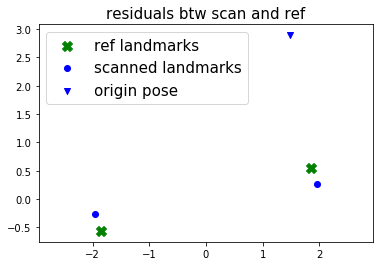

In [20]:
U_new = R@X+U_bar+t
utm_loc = np.array([[utm_x_loc],[utm_y_loc]])
utm_loc_decentral = utm_loc-U_bar
utm_loc_new = R@utm_loc_decentral+U_bar+t
plt.scatter(Y[0,:], Y[1,:], c='g', label='ref landmarks', marker='X', s=100)
plt.scatter(X[0,:], X[1,:], label='scanned landmarks',c='b')
plt.scatter(utm_loc_decentral[0], utm_loc_decentral[1], label='origin pose',c='b', marker="v")
# plt.scatter(w[0], w[1], label='origin pose',c='orange', marker="v")
# plt.scatter(U_bar[0], U_bar[1], label='origin pose',c='black', marker="v")
# plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
# plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend(fontsize=15)
plt.show()

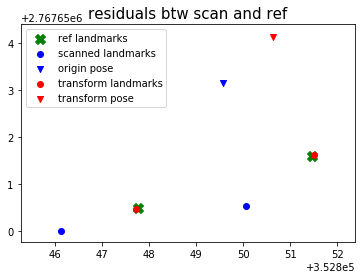

In [21]:
plt.scatter(Q[0,:], Q[1,:], c='g', label='ref landmarks', marker='X', s=100)
plt.scatter(U[0,:], U[1,:], label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='origin pose',c='b', marker="v")

plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

In [22]:
# calculate residuals
residuals = Q-U_new
residuals = np.absolute(residuals)
resid_scalar = residuals.sum()
print(resid_scalar)

0.13238875940442085


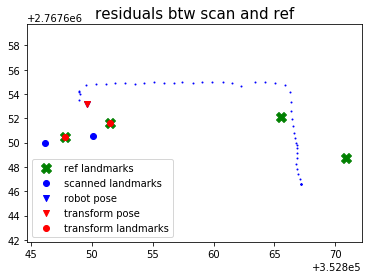

In [152]:
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='robot pose',c='b', marker="v")
plt.scatter(traj_x[0:len(traj_x)-400:50], traj_y[0:len(traj_y)-400:50],c='b',s=1)

plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")
plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

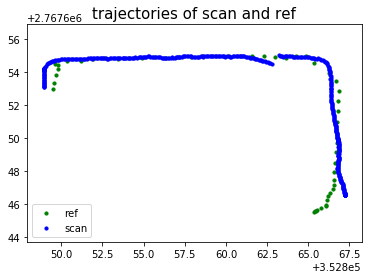

In [27]:
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test3_2021-07-25-18-23-39/traj_GPS.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(traj_x[0:len(traj_x)-653:20], traj_y[0:len(traj_y)-653:20],c='g',s=10, label='ref')

traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(traj_x[0:len(traj_x)-400:10], traj_y[0:len(traj_y)-400:10],c='b',s=10, label='scan')

plt.axis('equal')
plt.title('trajectories of scan and ref', fontsize=15)
plt.legend()
plt.show()

## find different negative boundary

(1024, 1024)


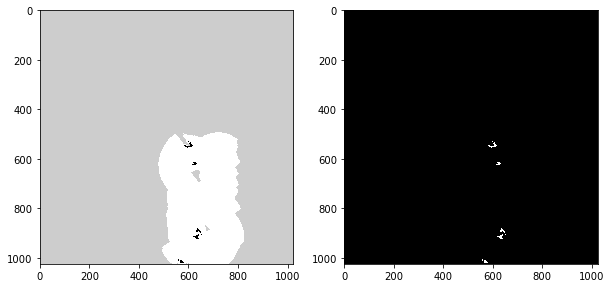

In [239]:
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path = directory+bag_name
shp_path = file_path + 'shapefiles/'

centroid_filteredNP_ref = np.load(file_path+'centroid_filteredList.npy')

raw_pgm = cv2.imread(file_path+"raw_modified.png")
print(raw_pgm.shape[:2])
raw_pgm_binary = np.zeros(raw_pgm.shape[:2],dtype=np.uint8)
raw_pgm_binary[raw_pgm[:,:,0]==0]=255
fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(raw_pgm_binary, cv2.COLOR_BGR2RGB))

>>>>num_objects: 23
# of points:  (1, 3)
# of points:  (355, 3)
x,y,r:  542.6078308692595 596.7372882922537 11.377591383670445
x,y,r:  543 597 11
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (178, 3)
x,y,r:  619.0043856969714 621.2551479544054 6.2009260106344355
x,y,r:  619 621 6
# of points:  (1, 3)
# of points:  (3, 3)
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (1, 3)
# of points:  (185, 3)
x,y,r:  889.7606662888138 638.1735614533536 6.792468815554205
x,y,r:  890 638 7
# of points:  (1, 3)
# of points:  (1, 3)
# of points:  (4, 3)
# of points:  (233, 3)
x,y,r:  913.2732089611673 632.6586831815803 6.7811994136308416
x,y,r:  913 633 7
# of points:  (5, 3)
# of points:  (149, 3)
x,y,r:  1011.3262081189314 565.563869627731 6.403888274797645
x,y,r:  1011 566 6
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (2, 3)
# of points:  (0,)


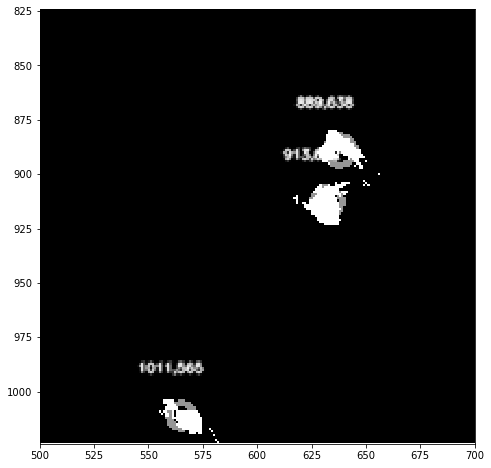

In [253]:
num_objects, labels = cv2.connectedComponents(raw_pgm_binary)
centre_x_list = []
centre_y_list = []
trunk_radius_utm_list = []
circle_bd = np.zeros(raw_pgm_binary.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)

for i in range(num_objects-1):
    A = []
    for x in range(1024):
        for y in range(1024):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    # print(k)

    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', centre_x, centre_y, radius_r)
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    centroid_rawList.append((int(centre_x+0.5),int(centre_y+0.5)))
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))
    trunk_radius_utm_list.append(int(radius_r+0.5))

    cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
    circle_bd[raw_pgm_binary==255]=255
    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x))+','+str(int(centre_y)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.2, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke

fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((500,700))
plt.ylim((1024,500))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

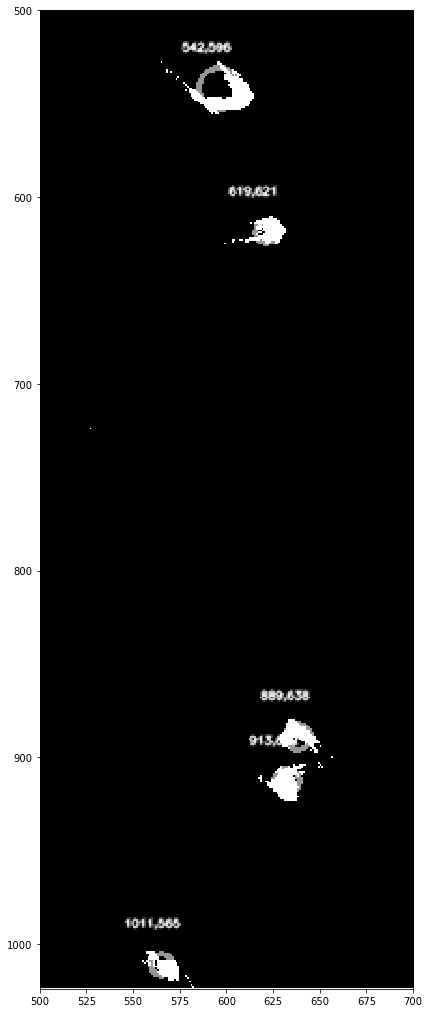

In [288]:
fig.ax = plt.subplots(figsize=(18,18))
plt.xlim((500,700))
plt.ylim((1024,500))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

In [ ]:
centroid_filteredList = []
while len(centroid_rawList) > 0:
    # centroid_tempList = []
    count = 1
    centroid = centroid_rawList.pop(0)
    # centroid_tempList.append(centroid)

    indexX = centroid[0]
    indexY = centroid[1]
    i = 0 
    # leng = len(centroidList)-1
    while True:
        if i < len(centroid_rawList):
            eDist = distance.euclidean(np.asarray(centroid), np.asarray(centroid_rawList[i]))
            if eDist < 25: # 1m
                centroid_tmp = centroid_rawList.pop(i)

                indexX += centroid_tmp[0]
                indexY += centroid_tmp[1]
                count += 1
                # centroid_tempList.append(centroid_tmp)
                centroid = (indexX/count, indexY/count)
                i -= 1
            i += 1
        else:
            break
    centroid_filteredList.append(centroid)

5
543 597
-18.9 4.25
619 621
-15.1 5.45
913 633
-0.4 6.05
1011 566
4.5 2.7


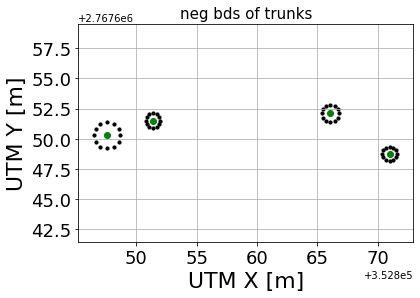

In [286]:
def transform_from_pixel2m(cX, cY,length):  # Here effects initial position
    # cX_m, cY_m = transformation(cX, cY, -0.5*np.pi, -int(length*(1-map_start_y)), int(length*(1-map_start_x)))
    
    cX_m = cX - int(length*(1-0.1))
    cY_m = cY - int(length*(1-0.5))
    
    cX_m /= 20
    cY_m /= 20
    return cX_m, cY_m

''' find neg bds of trunk '''

centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)
trunk_radius_utm_list = np.asarray(trunk_radius_utm_list)

number_of_point = 12
piece_rad = np.pi/(number_of_point/2)
print(len(centre_x_list))
for j in range(centre_x_list.shape[0]):
    if j == 2:
        continue
    neg_bd = []
    cX = centre_x_list[j]
    cY = centre_y_list[j]
    print(cX, cY)
    trunk_radius_utm = trunk_radius_utm_list[j]/10
    cX_m, cY_m = transform_from_pixel2m(cX, cY, raw_pgm.shape[0])
    print(cX_m, cY_m)
#     neg_bd.append((cX_m, cY_m))
    for i in range(number_of_point):
        neg_bd.append((cX_m+trunk_radius_utm*np.cos(piece_rad*i)+utm_x_ref, cY_m+trunk_radius_utm*np.sin(piece_rad*i)+utm_y_ref))
    neg_bd = np.asarray(neg_bd)
    plt.scatter(neg_bd[:,0], neg_bd[:,1], c='black', s=10)
    plt.scatter(cX_m+utm_x_ref, cY_m+utm_y_ref, c='g')
plt.ylabel('UTM Y [m]', fontsize=22)
plt.xticks(fontsize=18 )
plt.xlabel('UTM X [m]', fontsize=22)
plt.yticks(fontsize=18 )
plt.grid('on')
plt.axis('equal')
plt.title('neg bds of trunks', fontsize=15)
plt.show()

### test another traj

In [28]:
raw_pgm = cv2.imread("~/1.pgm")
# print(raw_pgm.shape[:2])
raw_pgm_binary = np.zeros(raw_pgm.shape[:2],dtype=np.uint8)
raw_pgm_binary[raw_pgm[:,:,0]==0]=255
fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(raw_pgm_binary, cv2.COLOR_BGR2RGB))

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='r')
plt.scatter(utm_x_loc, utm_y_loc, label='robot pose',c='b', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

In [166]:
file_path = "/home/ncslaber/mapping_node/mapping_ws/src/mapping_explorer/0906_demo_data/1tree/"

In [167]:
with open(file_path + 'cb_pose.csv', 'a+') as csvfile: # or w
                writer = csv.writer(csvfile)
                writer.writerows([[1],[2],[3]])

In [169]:
np.pi()

TypeError: 'float' object is not callable

(1024, 1024)


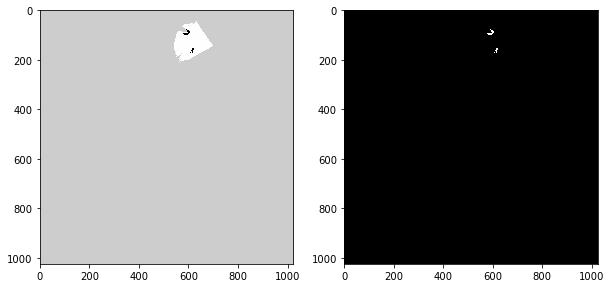

In [2]:
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test2_cut2_204-241/'
file_path = directory+bag_name
shp_path = file_path + 'shapefiles/'

centroid_filteredNP_ref = np.load(file_path+'centroid_filteredList.npy')

raw_pgm = cv2.imread(file_path+"1_modified.png")
print(raw_pgm.shape[:2])
raw_pgm_binary = np.zeros(raw_pgm.shape[:2],dtype=np.uint8)
raw_pgm_binary[raw_pgm[:,:,0]==0]=255
fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(raw_pgm_binary, cv2.COLOR_BGR2RGB))

>>>>num_objects: 9
# of points:  (273, 3)
x,y,r:  89.39527675607314 590.6600709912327 9.575896464803055
x,y,r:  89 591 10
# of points:  (151, 3)
x,y,r:  162.3126154341153 618.8915301281086 8.16523459571597
x,y,r:  162 619 8
# of points:  (1, 3)
# of points:  (4, 3)
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (1, 3)
# of points:  (1, 3)


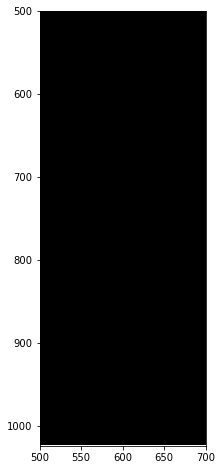

In [4]:
num_objects, labels = cv2.connectedComponents(raw_pgm_binary)
centre_x_list = []
centre_y_list = []
trunk_radius_utm_list = []
centroid_rawList = []
circle_bd = np.zeros(raw_pgm_binary.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)

for i in range(num_objects-1):
    A = []
    for x in range(1024):
        for y in range(1024):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    # print(k)

    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', centre_x, centre_y, radius_r)
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    centroid_rawList.append((int(centre_x+0.5),int(centre_y+0.5)))
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))
    trunk_radius_utm_list.append(int(radius_r+0.5))

    cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
    circle_bd[raw_pgm_binary==255]=255
    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x))+','+str(int(centre_y)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.2, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke

fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((500,700))
plt.ylim((1024,500))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

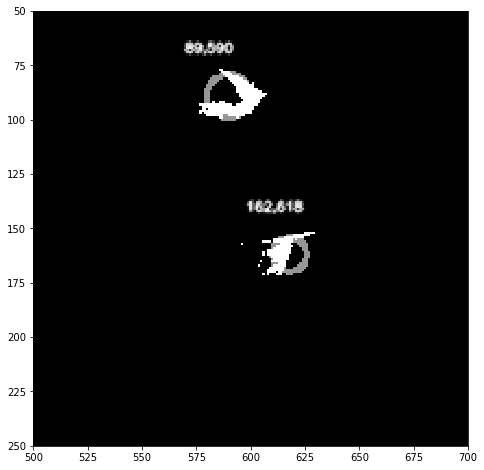

In [6]:

fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((500,700))
plt.ylim((250,50))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

In [8]:
centroid_filteredList = []
while len(centroid_rawList) > 0:
    # centroid_tempList = []
    count = 1
    centroid = centroid_rawList.pop(0)
    # centroid_tempList.append(centroid)

    indexX = centroid[0]
    indexY = centroid[1]
    i = 0 
    # leng = len(centroidList)-1
    while True:
        if i < len(centroid_rawList):
            eDist = dist.euclidean(np.asarray(centroid), np.asarray(centroid_rawList[i]))
            if eDist < 25: # 1m
                centroid_tmp = centroid_rawList.pop(i)

                indexX += centroid_tmp[0]
                indexY += centroid_tmp[1]
                count += 1
                # centroid_tempList.append(centroid_tmp)
                centroid = (indexX/count, indexY/count)
                i -= 1
            i += 1
        else:
            break
    centroid_filteredList.append(centroid)

2
89 591
-21.15 3.95
352846.00614660664 2767650.9633016796
162 619
-17.5 5.35
352849.65614660666 2767652.3633016795


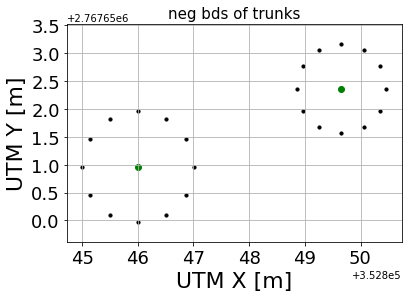

In [19]:
def transform_from_pixel2m(cX, cY,length):  # Here effects initial position
    # cX_m, cY_m = transformation(cX, cY, -0.5*np.pi, -int(length*(1-map_start_y)), int(length*(1-map_start_x)))
    
    cX_m = cX - int(length*(1-0.5))
    cY_m = cY - int(length*(1-0.5))
    
    cX_m /= 20
    cY_m /= 20
    return cX_m, cY_m

''' find neg bds of trunk '''

centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)
trunk_radius_utm_list = np.asarray(trunk_radius_utm_list)

number_of_point = 12
piece_rad = np.pi/(number_of_point/2)
print(len(centre_x_list))
for j in range(centre_x_list.shape[0]):
    if j == 2:
        continue
    neg_bd = []
    cX = centre_x_list[j]
    cY = centre_y_list[j]
    print(cX, cY)
    trunk_radius_utm = trunk_radius_utm_list[j]/10
    cX_m, cY_m = transform_from_pixel2m(cX, cY, raw_pgm.shape[0])
    print(cX_m, cY_m)
#     neg_bd.append((cX_m, cY_m))
    for i in range(number_of_point):
        neg_bd.append((cX_m+trunk_radius_utm*np.cos(piece_rad*i)+utm_x_ref, cY_m+trunk_radius_utm*np.sin(piece_rad*i)+utm_y_ref))
    neg_bd = np.asarray(neg_bd)
    plt.scatter(neg_bd[:,0], neg_bd[:,1], c='black', s=10)
    plt.scatter(cX_m+utm_x_ref, cY_m+utm_y_ref, c='g')
    print(cX_m+utm_x_ref, cY_m+utm_y_ref)
plt.ylabel('UTM Y [m]', fontsize=22)
plt.xticks(fontsize=18 )
plt.xlabel('UTM X [m]', fontsize=22)
plt.yticks(fontsize=18 )
plt.grid('on')
plt.axis('equal')
plt.title('neg bds of trunks', fontsize=15)
plt.show()

In [17]:
_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_ref, utm_y_ref = proj(lng, lat)

In [16]:
lat = 25.017225833333335
lng = 121.54183416666666

In [20]:
cX_m+utm_x_ref, cY_m+utm_y_ref

(352849.65614660666, 2767652.3633016795)

In [18]:
utm_x_ref, utm_y_ref

(352867.15614660666, 2767647.0133016794)